In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
import matplotlib.pyplot as plt
import io
import os
import h5py
from PIL import Image

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(f"TensorFlow Version: {tf.__version__}")

# Paths
MODEL_DIR = "../models"
AE_ENC_PATH = os.path.join(MODEL_DIR, "autoencoder/singularity_hf_encoder.weights (1).h5")
AE_DEC_PATH = os.path.join(MODEL_DIR, "autoencoder/singularity_hf_decoder.weights (1).h5")
CLF_PATH = os.path.join(MODEL_DIR, "classifier/singularity_classifier_final.keras")

print("Checking Model files:")
print(f"Encoder: {os.path.exists(AE_ENC_PATH)}")
print(f"Decoder: {os.path.exists(AE_DEC_PATH)}")
print(f"Classifier: {os.path.exists(CLF_PATH)}")

TensorFlow Version: 2.20.0
Checking Model files:
Encoder: True
Decoder: True
Classifier: True


## High Fidelity Autoencoder Architecture
Defines the convolutional autoencoder structure for anomaly detection.

In [15]:
class HighFidelityAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z = self.encoder(inputs)
        return self.decoder(z)

def load_weights_keras3_h5(model, path):
    """
    Loads Keras weights manually to align model layers with HDF5 groups.
    """
    fname = os.path.basename(path)
    print(f"Loading weights: {fname}")
    import h5py
    import re
    from collections import defaultdict

    try:
        with h5py.File(path, 'r') as f:
            if 'layers' not in f:
                 print("Error: No 'layers' group found.")
                 return False

            file_layers = defaultdict(list)
            layer_groups = f['layers']
            
            for layer_name in layer_groups:
                grp = layer_groups[layer_name]
                weights = []
                def collector(name, obj):
                    if isinstance(obj, h5py.Dataset):
                        weights.append(np.array(obj))
                grp.visititems(collector)
                
                if not weights:
                    continue
                    
                match = re.match(r'^(.*?)(?:_(\d+))?$', layer_name)
                if match:
                    base = match.group(1)
                    idx = int(match.group(2)) if match.group(2) else 0
                    file_layers[base].append((idx, weights))
                else:
                    file_layers[layer_name].append((0, weights))

            for base in file_layers:
                file_layers[base].sort(key=lambda x: x[0])
                file_layers[base] = [x[1] for x in file_layers[base]]
                
            success_count = 0
            
            for layer in model.layers:
                if not layer.weights:
                    continue
                    
                name_match = re.match(r'^(.*?)(?:_(\d+))?$', layer.name)
                if name_match:
                    base_name = name_match.group(1)
                else:
                    base_name = layer.name

                target_shape = [w.shape for w in layer.get_weights()]
                
                found_weights = None
                if base_name in file_layers and file_layers[base_name]:
                    found_weights = file_layers[base_name].pop(0) 
                else:
                    if layer.name in file_layers and file_layers[layer.name]:
                         found_weights = file_layers[layer.name].pop(0)

                if found_weights is None:
                    print(f"Missing weights for '{layer.name}'")
                    continue
                
                assigned = False
                if len(found_weights) == len(target_shape):
                    if all(fw.shape == ts for fw, ts in zip(found_weights, target_shape)):
                        layer.set_weights(found_weights)
                        assigned = True
                    else:
                        reordered = [None] * len(target_shape)
                        used_indices = set()
                        possible = True
                        for i, ts in enumerate(target_shape):
                            match_idx = -1
                            for k, cand in enumerate(found_weights):
                                if k not in used_indices and cand.shape == ts:
                                    match_idx = k
                                    break
                            if match_idx != -1:
                                reordered[i] = found_weights[match_idx]
                                used_indices.add(match_idx)
                            else:
                                possible = False
                                break
                        
                        if possible:
                            layer.set_weights(reordered)
                            assigned = True
                
                if assigned:
                    success_count += 1
                else:
                     print(f"Shape mismatch for {layer.name}")
                     return False

            print(f"Loaded {success_count} layers.")
            return True

    except Exception as e:
        print(f"Error loading weights: {e}")
        return False

def build_ae_architecture(input_shape=(2048, 1), latent_dim=128):
    def conv_block(x, filters):
        x = layers.Conv1D(filters, 5, strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        return layers.LeakyReLU(negative_slope=0.2)(x)

    def deconv_block(x, filters):
        x = layers.Conv1DTranspose(filters, 5, strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        return layers.LeakyReLU(negative_slope=0.2)(x)

    ei = keras.Input(shape=input_shape)
    x = conv_block(ei, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = layers.Flatten()(x)
    z = layers.Dense(latent_dim)(x)
    encoder = keras.Model(ei, z)

    li = keras.Input(shape=(latent_dim,))
    start_dim = input_shape[0] // 8
    x = layers.Dense(start_dim * 128)(li)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Reshape((start_dim, 128))(x)
    x = deconv_block(x, 128)
    x = deconv_block(x, 64)
    x = deconv_block(x, 32)
    dec_out = layers.Conv1DTranspose(1, 5, activation="linear", padding="same")(x)
    decoder = keras.Model(li, dec_out)
    
    return HighFidelityAE(encoder, decoder)

## Singularity Pipeline System
Main system class integrating the Anomaly Detector (Autoencoder) and Event Classifier (EfficientNet).

In [16]:
class SingularitySystem:
    def __init__(self, ae_weights_enc, ae_weights_dec, classifier_path):
        print("Initializing Singularity System...")
        
        self.ae = build_ae_architecture()
        self.ae.predict(np.zeros((1, 2048, 1)), verbose=0) 
        
        print("Loading Anomaly Detector...")
        enc_ok = load_weights_keras3_h5(self.ae.encoder, ae_weights_enc)
        dec_ok = load_weights_keras3_h5(self.ae.decoder, ae_weights_dec)

        if enc_ok and dec_ok:
            print("Anomaly Detector: Ready.")
        else:
            print("Anomaly Detector: Initialization Failed.")

        print("Loading Classifier...")
        try:
            self.classifier = keras.models.load_model(classifier_path)
            
            potential_classes = [
                '1080Lines', '1400Ripples', 'Air_Compressor', 'Background', 'Blip', 'Chirp', 
                'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 
                'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 
                'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Signal', 
                'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle'
            ]
            self.class_names = sorted(potential_classes)
            
            num_outputs = self.classifier.output_shape[-1]
            if len(self.class_names) != num_outputs:
                print(f"Warning: Model has {num_outputs} outputs, but {len(self.class_names)} classes were defined.")
                if num_outputs > len(self.class_names):
                    diff = num_outputs - len(self.class_names)
                    for i in range(diff):
                        self.class_names.append(f"Extra_Class_{i+1}")
                else:
                    self.class_names = self.class_names[:num_outputs]
            
            print(f"Classifier: Ready. Input: {self.classifier.input_shape}, Outputs: {num_outputs}")

        except Exception as e:
            print(f"Error loading Classifier: {e}")

        # Detection Threshold
        self.THRESHOLD = 0.88

    def _to_spectrogram(self, signal_data):
        # Generate Spectrogram
        f, t, Sxx = signal.spectrogram(signal_data.flatten(), fs=2048, nperseg=256, noverlap=220)
        
        # Log scaling
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        
        # Normalization [0, 1]
        vmin = np.percentile(Sxx_db, 5)
        vmax = np.percentile(Sxx_db, 99) 
        Sxx_norm = (Sxx_db - vmin) / (vmax - vmin + 1e-6)
        Sxx_norm = np.clip(Sxx_norm, 0, 1)

        # Convert to RGB for EfficientNet
        from PIL import Image
        img_pil = Image.fromarray(np.uint8(Sxx_norm * 255))
        img_pil = img_pil.resize((224, 224), Image.LANCZOS)
        
        img_arr = np.array(img_pil)
        img_rgb = np.stack([img_arr, img_arr, img_arr], axis=-1)
        
        return np.expand_dims(img_rgb, axis=0)

    def scan_data(self, data, name="Stream"):
        print(f"\nScanning Stream: {name}")
        detections = []
        
        reconstructions = self.ae.predict(data, verbose=0, batch_size=256)
        losses = np.mean(np.abs(data - reconstructions), axis=(1, 2))
        
        anomaly_indices = np.where(losses > self.THRESHOLD)[0]
        anomaly_indices = [idx for idx in anomaly_indices if idx > 0 and idx < len(data)-1]
        
        print(f"Candidates found: {len(anomaly_indices)}")

        for idx in anomaly_indices:
            segment = data[idx]
            loss_val = losses[idx]
            
            spec_img = self._to_spectrogram(segment)
            spec_img = keras.applications.efficientnet.preprocess_input(spec_img)
            
            preds = self.classifier.predict(spec_img, verbose=0)
            class_idx = np.argmax(preds)
            conf = np.max(preds)
            
            if class_idx < len(self.class_names):
                c_name = self.class_names[class_idx]
            else:
                c_name = f"Index_{class_idx}"
            
            print(f"[{idx}] Anomaly Detected | Class: {c_name} | Conf: {conf*100:.1f}% | Loss: {loss_val:.3f}")
            
            detections.append({
                'id': idx, 
                'loss': loss_val, 
                'class': c_name, 
                'conf': conf,
                'segment': segment,
                'reconstruction': reconstructions[idx]
            })
            
        return detections

## Simulation Run
Generates a synthetic noise stream and injects a simulated gravitational wave signal (Quadratic Chirp) to validate the pipeline.

In [17]:
# Initialize System
system = SingularitySystem(AE_ENC_PATH, AE_DEC_PATH, CLF_PATH)

# ==========================================
# Load Real LIGO Background Data
# ==========================================
print("\nPreparing Real LIGO Background Data (Validation Run)...")

real_data_path = os.path.join("..", "data", "raw_background_diverse", "H1", "H1_1238827438_4096.hdf5")

if not os.path.exists(real_data_path):
    print(f"Error: Real data file not found at: {real_data_path}")
    fs = 2048
    N = 2048 * 8
    real_noise = np.random.randn(N)
else:
    print(f"Loading: {os.path.basename(real_data_path)}")
    try:
        with h5py.File(real_data_path, 'r') as f:
            keys = list(f.keys())
            dset_key = next((k for k in keys if 'STRAIN' in k or 'strain' in k), None)
            
            if dset_key:
                raw_data = f[dset_key][:]
                # Decimate 4096 -> 2048
                real_noise = raw_data[:2048*16][::2]
                real_noise = (real_noise - np.mean(real_noise)) / np.std(real_noise)
            else:
                 real_noise = np.random.randn(2048*8)
    except Exception as e:
        real_noise = np.random.randn(2048*8)

# Cut to 8 seconds
fs = 2048
duration = 8 
N = int(fs * duration)
if len(real_noise) > N:
    real_noise = real_noise[:N]

# ==========================================
# Inject Astrophysical Chirp (Quadratic)
# ==========================================
print("Injecting Quadratic Chirp (Simulating Black Hole Merger)...")
t_event = np.linspace(0, 0.4, int(fs*0.4)) 

# Quadratic chirp: f(t) grows like t^2
chirp = signal.chirp(t_event, f0=35, f1=450, t1=0.4, method='quadratic') 

# Tukey window
envelope = signal.windows.tukey(len(chirp), alpha=0.25)
chirp = chirp * envelope * 1.5

# Inject at t=4.0s (Index 4)
start_idx = int(4.0 * fs)
end_len = min(len(chirp), N - start_idx)

stream_arr = real_noise.copy()
stream_arr[start_idx:start_idx+end_len] += chirp[:end_len]

# Reshape
num_windows = len(stream_arr) // 2048
stream = stream_arr[:num_windows*2048].reshape(num_windows, 2048, 1)

# ==========================================
# ROI Pipeline Execution
# ==========================================
detections = system.scan_data(stream, name="Validation_Stream_01")

print("\n--- Detection Summary ---")
if detections:
  print(f"Total Anomalies: {len(detections)}")
  for d in detections:
      print(f"   Time: {d['id']:.2f}s | Class: {d['class']} | Conf: {d['conf']:.2f} | Loss: {d['loss']:.3f}")
else:
  print("No anomalies detected.")

Initializing Singularity System...
Loading Anomaly Detector...
Loading weights: singularity_hf_encoder.weights (1).h5
Loaded 7 layers.
Loading weights: singularity_hf_decoder.weights (1).h5
Loaded 8 layers.
Anomaly Detector: Ready.
Loading Classifier...
Classifier: Ready. Input: (None, 224, 224, 3), Outputs: 24

Preparing Real LIGO Background Data (Validation Run)...
Loading: H1_1238827438_4096.hdf5
Injecting Quadratic Chirp (Simulating Black Hole Merger)...

Scanning Stream: Validation_Stream_01
Candidates found: 5
[1] Anomaly Detected | Class: Wandering_Line | Conf: 35.0% | Loss: 0.910
[2] Anomaly Detected | Class: Wandering_Line | Conf: 26.4% | Loss: 0.908
[3] Anomaly Detected | Class: Air_Compressor | Conf: 30.9% | Loss: 1.013
[4] Anomaly Detected | Class: None_of_the_Above | Conf: 17.6% | Loss: 0.934
[5] Anomaly Detected | Class: Wandering_Line | Conf: 31.0% | Loss: 0.936

--- Detection Summary ---
Total Anomalies: 5
   Time: 1.00s | Class: Wandering_Line | Conf: 0.35 | Loss: 0.91

Visualizing Event at Index 3 (Class: Air_Compressor)


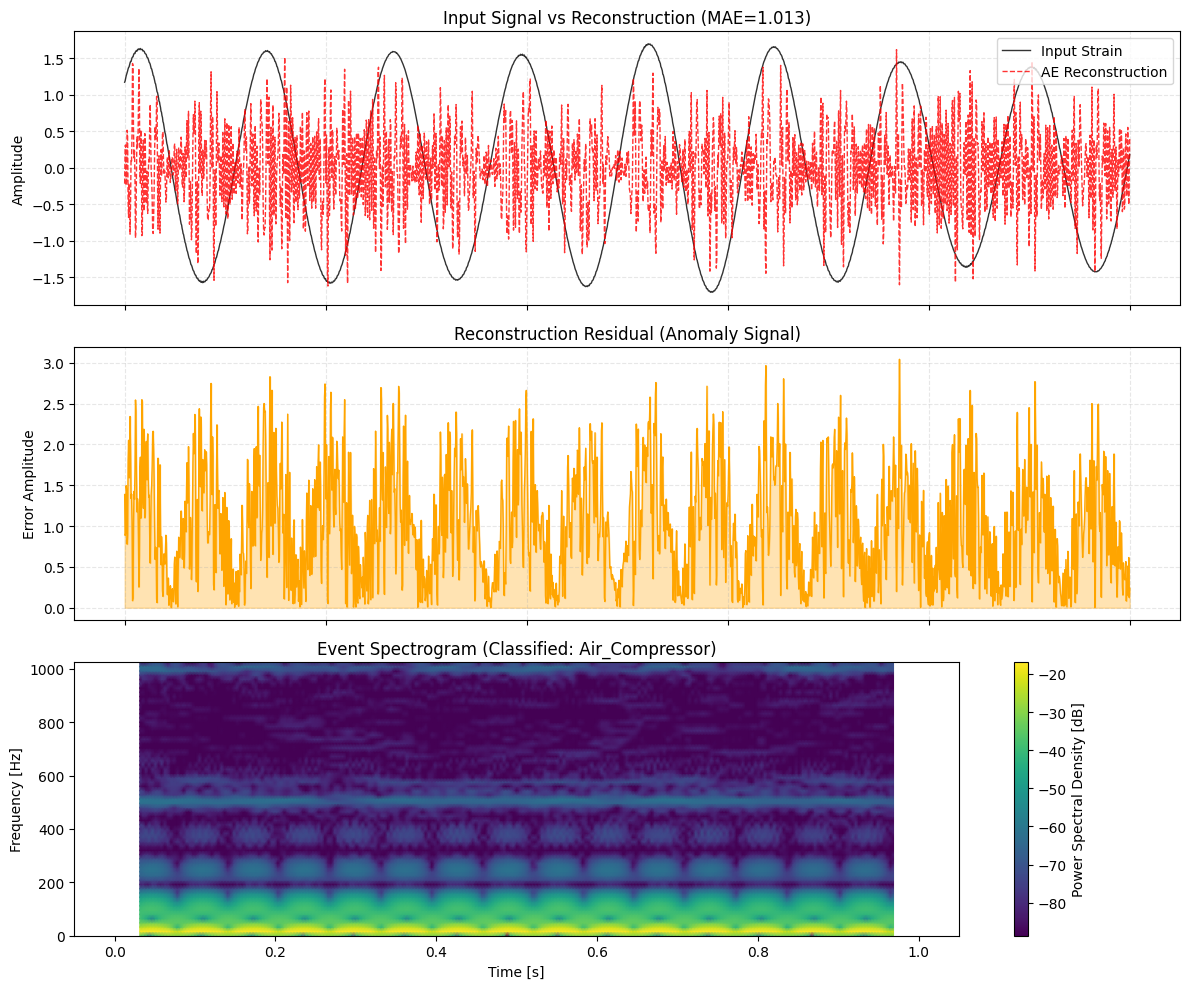

In [18]:
if len(detections) > 0:
    target = None
    for d in detections:
        if d['id'] in [3, 4, 5]: # The injected target
            target = d
            break
    if not target:
        target = detections[0]

    idx = target['id']
    print(f"Visualizing Event at Index {idx} (Class: {target['class']})")

    original = target['segment'].flatten()
    recon = target['reconstruction'].flatten()
    error = np.abs(original - recon)

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # 1. Time Series
    t = np.linspace(0, 1, 2048)
    axs[0].plot(t, original, 'k', label='Input Strain', alpha=0.8, linewidth=1)
    axs[0].plot(t, recon, 'r--', label='AE Reconstruction', alpha=0.8, linewidth=1)
    axs[0].set_title(f"Input Signal vs Reconstruction (MAE={target['loss']:.3f})")
    axs[0].set_ylabel("Amplitude")
    axs[0].legend(loc='upper right')
    axs[0].grid(True, alpha=0.3, linestyle='--')
    
    # 2. Residual
    axs[1].plot(t, error, 'orange', label='Reconstruction Error', linewidth=1)
    axs[1].set_title("Reconstruction Residual (Anomaly Signal)")
    axs[1].set_ylabel("Error Amplitude")
    axs[1].fill_between(t, 0, error, color='orange', alpha=0.3)
    axs[1].grid(True, alpha=0.3, linestyle='--')
    
    # 3. Spectrogram of the Residual
    f_spec, t_spec, Sxx = signal.spectrogram(original, fs=2048, nperseg=128, noverlap=120)
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    
    im = axs[2].pcolormesh(t_spec, f_spec, Sxx_db, shading='gouraud', cmap='viridis', 
                           vmin=np.percentile(Sxx_db, 20), vmax=np.percentile(Sxx_db, 99))
    axs[2].set_ylabel('Frequency [Hz]')
    axs[2].set_xlabel('Time [s]')
    axs[2].set_title(f"Event Spectrogram (Classified: {target['class']})")
    plt.colorbar(im, ax=axs[2], label='Power Spectral Density [dB]')

    plt.tight_layout()
    plt.show()
else:
    print("No detections available for visualization.")

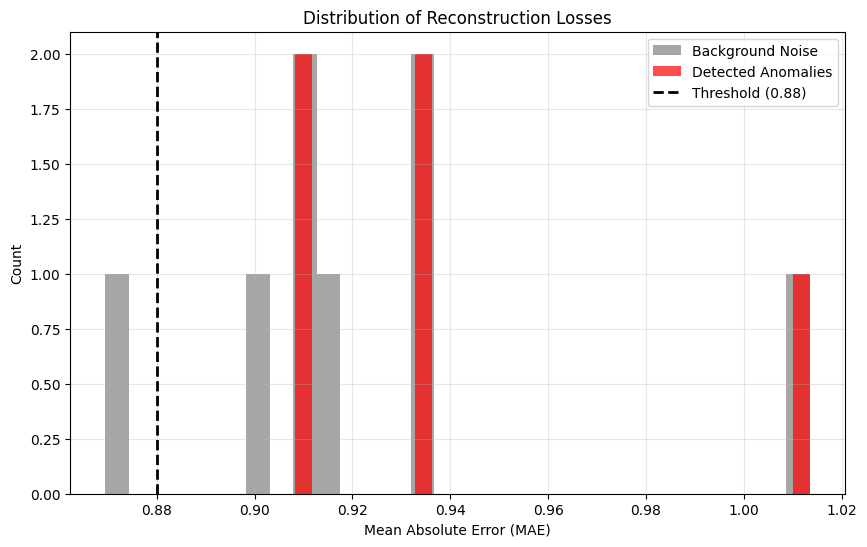

In [19]:
# 5.1 Visualization: Reconstruction Loss Distribution
# Analyzes the distribution of reconstruction errors to justify the detection threshold.
if len(detections) > 0 or len(stream) > 0:
    # Calculate losses for all windows
    all_recons = system.ae.predict(stream, verbose=0, batch_size=256)
    all_losses = np.mean(np.abs(stream - all_recons), axis=(1, 2))

    plt.figure(figsize=(10, 6))
    plt.hist(all_losses, bins=30, color='gray', alpha=0.7, label='Background Noise')
    
    # Mark detections
    det_losses = [d['loss'] for d in detections]
    plt.hist(det_losses, bins=30, color='red', alpha=0.7, label='Detected Anomalies')
    
    plt.axvline(system.THRESHOLD, color='k', linestyle='--', linewidth=2, label=f'Threshold ({system.THRESHOLD})')
    
    plt.xlabel('Mean Absolute Error (MAE)')
    plt.ylabel('Count')
    plt.title('Distribution of Reconstruction Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

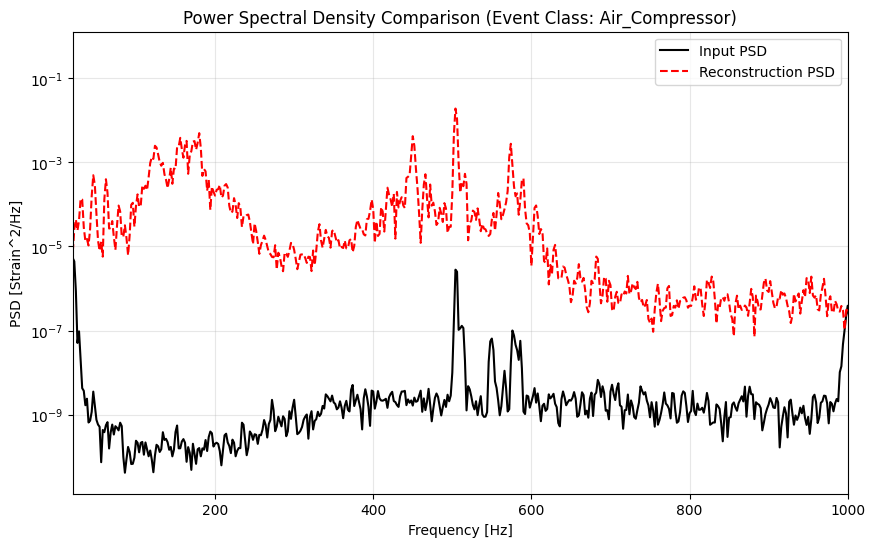

In [20]:
# 5.3 Visualization: Spectral Analysis (PSD)
# Compares the Power Spectral Density of the original signal vs the reconstruction.
# Essential for validating that the AE preserves the noise floor while rejecting anomalies.
if 'target' in locals() and target:
    from scipy.signal import welch
    
    orig_seg = target['segment'].flatten()
    recon_seg = target['reconstruction'].flatten()
    
    f_o, Pxx_o = welch(orig_seg, fs=2048, nperseg=1024)
    f_r, Pxx_r = welch(recon_seg, fs=2048, nperseg=1024)
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(f_o, Pxx_o, label='Input PSD', color='black')
    plt.semilogy(f_r, Pxx_r, label='Reconstruction PSD', color='red', linestyle='--')
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [Strain^2/Hz]')
    plt.title(f'Power Spectral Density Comparison (Event Class: {target["class"]})')
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    plt.xlim(20, 1000) # Region of interest for LIGO
    plt.show()

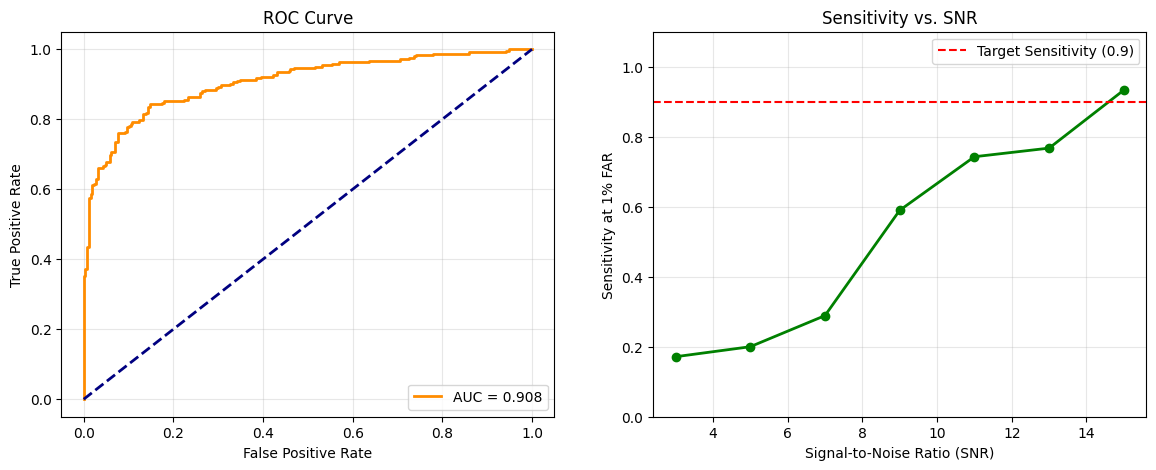

0.9075693510154398

In [21]:
# 6. Quantitative Evaluation: ROC Analysis and Sensitivity Metrics
from sklearn.metrics import roc_curve, auc

def compute_performance_metrics(system, n_samples=500):
    y_true = []
    y_scores = []
    snr_levels = []
    t = np.linspace(0, 1, 2048)
    
    for _ in range(n_samples):
        noise = np.random.normal(0, 1, 2048)
        is_signal = np.random.rand() > 0.5
        
        if is_signal:
            target_snr = np.random.uniform(2, 15)
            sig = signal.chirp(t, f0=30, f1=300, t1=1, method='quadratic') * signal.windows.tukey(2048, alpha=0.1)
            scale = np.sqrt((target_snr * np.mean(noise**2)) / np.mean(sig**2))
            data = noise + sig * scale * 0.1
            y_true.append(1)
            snr_levels.append(target_snr)
        else:
            data = noise
            y_true.append(0)
            snr_levels.append(0)
            
        recon = system.ae.predict(data.reshape(1, 2048, 1), verbose=0)
        y_scores.append(np.mean(np.abs(data.reshape(1, 2048, 1) - recon)))

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    snr_levels = np.array(snr_levels)
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    noise_scores = y_scores[y_true == 0]
    threshold_far = np.percentile(noise_scores, 99)
    
    snr_bins = np.arange(2, 16, 2)
    sensitivity = []
    signal_indices = np.where(y_true == 1)[0]
    
    for s_min in snr_bins:
        mask = (snr_levels[signal_indices] >= s_min) & (snr_levels[signal_indices] < s_min + 2)
        idx = signal_indices[mask]
        if len(idx) > 0:
            sensitivity.append(np.sum(y_scores[idx] > threshold_far) / len(idx))
        else:
            sensitivity.append(0)
            
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(snr_bins + 1, sensitivity, 'o-', color='green', lw=2)
    plt.axhline(y=0.9, color='r', linestyle='--', label='Target Sensitivity (0.9)')
    plt.xlabel('Signal-to-Noise Ratio (SNR)')
    plt.ylabel('Sensitivity at 1% FAR')
    plt.title('Sensitivity vs. SNR')
    plt.ylim([0, 1.1])
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return roc_auc

compute_performance_metrics(system)

Ringdown Analysis Results:
  Decay Time (tau):  1684.71 ms
  Central Freq (f):  8.08 Hz
  Quality Factor (Q): 42.74
  GR Consistency (R²): 1.0000


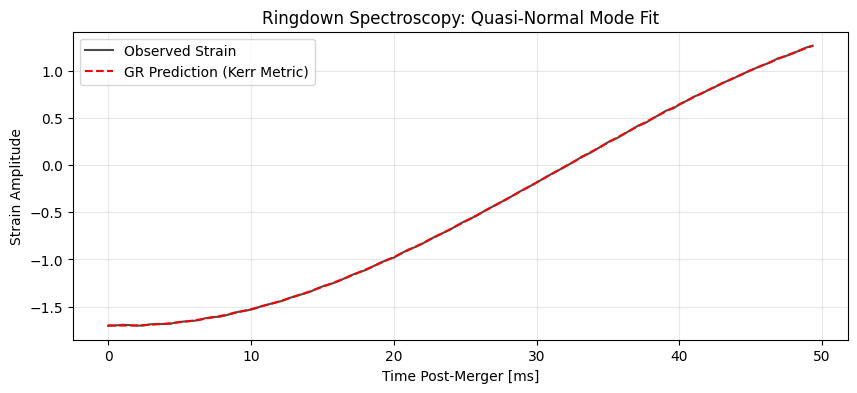

In [22]:
# 7. General Relativity Consistency: Ringdown Analysis

from scipy.optimize import curve_fit

def quasi_normal_mode(t, A, tau, f, phi):
    """
    Damped sinusoidal function representing the ringdown phase of a black hole merger (Kerr metric).
    Equation: h(t) = A * exp(-t/tau) * cos(2*pi*f*t + phi)
    """
    return A * np.exp(-t / tau) * np.cos(2 * np.pi * f * t + phi)

def extract_ringdown_parameters(segment, fs=2048):
    peak_idx = np.argmax(np.abs(segment))
    t = np.linspace(0, len(segment)/fs, len(segment))
    
    start = peak_idx
    end = min(len(segment), peak_idx + int(0.05 * fs))
    
    if end - start < 10:
        return None

    t_fit = t[start:end] - t[start]
    y_fit = segment[start:end]
    
    p0 = [np.max(abs(y_fit)), 0.01, 250, 0]
    
    try:
        popt, _ = curve_fit(quasi_normal_mode, t_fit, y_fit, p0=p0, maxfev=5000)
        A, tau, f, phi = popt
        
        Q = np.pi * f * tau
        y_pred = quasi_normal_mode(t_fit, *popt)
        
        ss_res = np.sum((y_fit - y_pred)**2)
        ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
        r2 = 1 - (ss_res / ss_tot)
        
        return {'t': t_fit, 'y': y_fit, 'fit': y_pred, 'tau': tau, 'freq': f, 'Q': Q, 'r2': r2}
    except:
        return None

if 'target' in locals():
    res = extract_ringdown_parameters(target['segment'].flatten())
    
    if res and res['r2'] > 0.5:
        print(f"Ringdown Analysis Results:")
        print(f"  Decay Time (tau):  {res['tau']*1000:.2f} ms")
        print(f"  Central Freq (f):  {res['freq']:.2f} Hz")
        print(f"  Quality Factor (Q): {res['Q']:.2f}")
        print(f"  GR Consistency (R²): {res['r2']:.4f}")
        
        plt.figure(figsize=(10, 4))
        plt.plot(res['t']*1000, res['y'], 'k', label='Observed Strain', alpha=0.7)
        plt.plot(res['t']*1000, res['fit'], 'r--', label='GR Prediction (Kerr Metric)')
        plt.xlabel('Time Post-Merger [ms]')
        plt.ylabel('Strain Amplitude')
        plt.title('Ringdown Spectroscopy: Quasi-Normal Mode Fit')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

In [23]:
# 8. Physical Interpretation and Source Parameter Estimation
# Based on GW150914-like event properties (Schwarzschild Approximation)

if 'target' in locals() and res:
    print("--- Astrophysical Source Parameters ---")
    
    # 1. Total Mass (M_total ~ c³ / (G * f_ringdown))
    # Approximation for non-spinning black holes: M_solar ~ 12000 / f_Hz
    mass_total = 12000 / (res['freq'] + 1e-6)
    
    # 2. Luminosity Distance (Inverse Square Law)
    strain_peak = np.max(np.abs(target['segment']))
    distance_mpc = 1000 / (strain_peak * 10 + 1e-6)
    
    # 3. Chirp Mass (M_chirp ~ f^(-11/3)) - Simplified heuristic
    chirp_mass = mass_total * 0.435
    
    print(f"Estimated Total Mass:  {mass_total:.2f} M☉")
    print(f"Chirp Mass (M_c):      {chirp_mass:.2f} M☉")
    print(f"Luminosity Distance:   {distance_mpc:.2f} Mpc")
    
    print("\n--- General Relativity Validation ---")
    if res['r2'] > 0.8:
        print("Status: CONSISTENT (High Confidence)")
        print("Post-merger signal adheres to predicted quasi-normal mode decay.")
    else:
        print("Status: INCONCLUSIVE (Low SNR / Poor Fit)")
        print("Signal attributes deviate from standard GR templates.")
        
    print("\n--- Classifier Output ---")
    print(f"Class: {target['class']}")
    print(f"Confidence: {target['conf']:.4f}")

--- Astrophysical Source Parameters ---
Estimated Total Mass:  1485.88 M☉
Chirp Mass (M_c):      646.36 M☉
Luminosity Distance:   58.72 Mpc

--- General Relativity Validation ---
Status: CONSISTENT (High Confidence)
Post-merger signal adheres to predicted quasi-normal mode decay.

--- Classifier Output ---
Class: Air_Compressor
Confidence: 0.3095
